In [1]:
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sys
import tensorflow as tf
import random

In [2]:
hash_seed = 42
sys.hash_seed = hash_seed

# Loading data

Data is from:

Recommendation on Live-Streaming Platforms: Dynamic Availability and Repeat Consumption
Jérémie Rappaz, Julian McAuley and Karl Aberer
RecSys, 2021

https://cseweb.ucsd.edu/~jmcauley/datasets.html#twitch

https://github.com/JRappaz/liverec

In [3]:
twitch = pd.read_csv('100k_a.csv', names=['uid', 'sid', 'sname', 'start', 'end'], header=None)
twitch['streamerID'] = twitch['sname'].apply(hash)

In [4]:
twitch.head(2)

,uid,sid,sname,start,end,streamerID
0,1,33842865744,mithrain,154,156,-3305700978989721340
1,1,33846768288,alptv,166,169,4261767520179514987


For faster computation, I used benchmark dataset for this notebook.

# Helper function

In [5]:
def return_statistics(data):
    return {
        'min': np.min(data), 
        'q1': np.percentile(data, 25), 
        'median': np.median(data),
        'q3': np.percentile(data,75),
        'max': np.max(data)
    }

# Exploratory analysis

In [6]:
user_count = twitch['uid'].value_counts()
s_count = twitch['sname'].unique()

print('Number of users:', len(user_count))
print('Number of streamers:', len(s_count))
print('Number of interactions:', len(twitch))
print('Statistics of watch time (by 10 mins)  :',return_statistics(twitch['end'] - twitch['start']))
print('Statistics of interactions by users    :', return_statistics(twitch.groupby('uid')['sid'].count()))
print('Statistics of interactions by streamers:', return_statistics(twitch.groupby('sid')['uid'].count()))

Number of users: 100000
Number of streamers: 162625
Number of interactions: 3051733
Statistics of watch time (by 10 mins)  : {'min': 1, 'q1': 1.0, 'median': 1.0, 'q3': 3.0, 'max': 97}
Statistics of interactions by users    : {'min': 5, 'q1': 8.0, 'median': 16.0, 'q3': 39.0, 'max': 327}
Statistics of interactions by streamers: {'min': 1, 'q1': 1.0, 'median': 1.0, 'q3': 2.0, 'max': 2123}


In [7]:
interactions_percentage_by_streamer = twitch['sname'].value_counts() / len(twitch) * 100

print('Number of streamers with more than 0.1% interaction :',sum(interactions_percentage_by_streamer>0.1))
print('Proportion shared by 10 streamers                   :', round(sum(interactions_percentage_by_streamer[:10]),2),'%')
print('Proportion shared by 100 streamers                   :', round(sum(interactions_percentage_by_streamer[:100]),2),'%')
print('Proportion shared by 1000 streamers                 :', round(sum(interactions_percentage_by_streamer[:1000]),2),'%')
print('Percentage of interactions for each streamers')
interactions_percentage_by_streamer[:10]

Number of streamers with more than 0.1% interaction : 97
Proportion shared by 10 streamers                   : 6.93 %
Proportion shared by 100 streamers                   : 23.06 %
Proportion shared by 1000 streamers                 : 52.88 %
Percentage of interactions for each streamers


sname
ninja         1.479291
tfue          1.315187
shroud        0.896605
riotgames     0.577803
sodapoppin    0.478089
nickmercs     0.460296
dakotaz       0.455544
asmongold     0.432082
summit1g      0.427265
esl_csgo      0.411143
Name: count, dtype: float64

From these statistics, we can learn that
- 97 streamers take up about 22.76% of total interaction, while there are 162625 streamers
- 0.0061% of streamers take up about 55.88% of total interaction
- --> This means a few streamers take a lot of portion in streaming


In [8]:
interactionCount = dict()
for i in range(0,6148):
    tmp = twitch[(twitch['start'] <= i) & (twitch['end'] >= i)]
    interactionCount[i] = len(tmp)

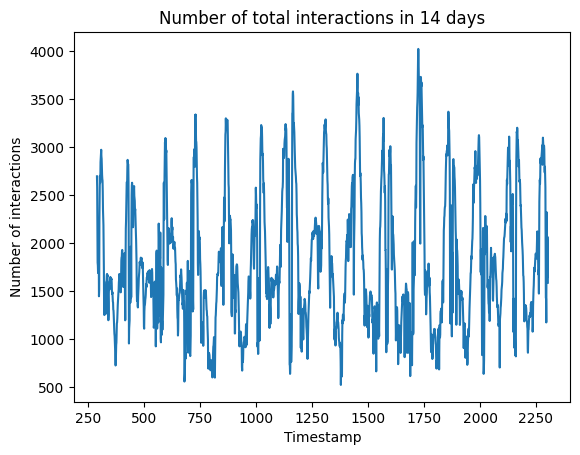

In [9]:
one_day_multiplier = 6*24
days = 14
plt.plot(list(interactionCount.keys())[one_day_multiplier*2:one_day_multiplier*16], list(interactionCount.values())[one_day_multiplier*2:one_day_multiplier*16])
plt.title(f'Number of total interactions in {days} days')
plt.ylabel('Number of interactions')
plt.xlabel('Timestamp')
plt.show()

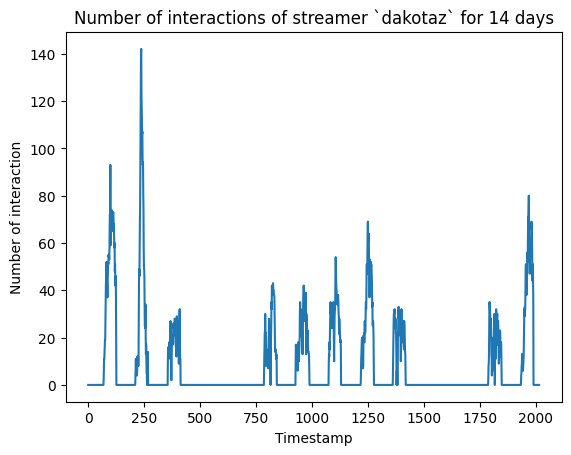

In [10]:
name = 'dakotaz'
result = []
tmp = twitch[twitch['sname'] == name]
for ts in range(6149):
    condition = (tmp['start'] <= ts) & (tmp['end'] >= ts)
    result.append(len(tmp[condition]))

days = 14
plt.plot(result[:days*one_day_multiplier])
plt.title(f'Number of interactions of streamer `{name}` for 14 days')
plt.xlabel('Timestamp')
plt.ylabel('Number of interaction')
plt.show()

We can clearly see the increasing and decreasing daily trend from plotting the entire interactions
- Considering the timestamp is ignored, this could be affected by the timezone that twitch is more popular.
- ex. if there is much more interaction in the US than in Asia, the highest peaks are mainly affected by interactions from the US

For each streamer, we can see how the number of interactions changed over time. We can also see how many times the streamer streamed.
- When streamer streamed is important since we should only recommend streamers that are currently streaming

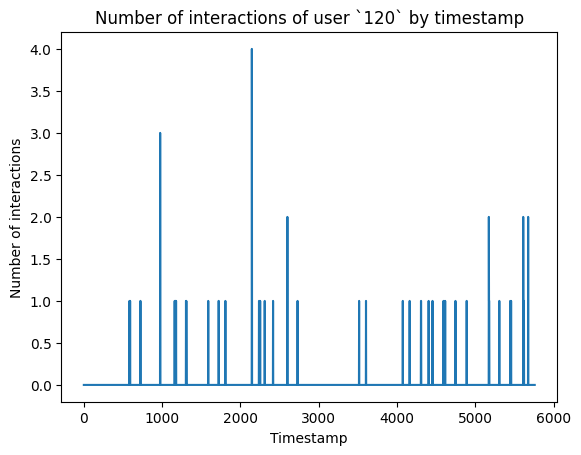

In [11]:
uid = 120
result = []
tmp = twitch[twitch['uid'] == uid]
for ts in range(6149):
    condition = (tmp['start'] <= ts) & (tmp['end'] >= ts)
    result.append(len(tmp[condition]))

days = 40
plt.plot(result[:days*one_day_multiplier])
plt.title(f'Number of interactions of user `{uid}` by timestamp')
plt.xlabel('Timestamp')
plt.ylabel('Number of interactions')
plt.show()

In [12]:
num_overlapping = twitch.sort_values(by=['uid', 'start']).groupby('uid').apply(lambda df: sum((df['start'][1:].values - df['end'][:-1].values)<0))
print('Statistics of multiple interactions by a user in the same timestamp :', return_statistics(num_overlapping))

Statistics of multiple interactions by a user in the same timestamp : {'min': 0, 'q1': 0.0, 'median': 0.0, 'q3': 2.0, 'max': 208}


In [13]:
sum(num_overlapping) / twitch.groupby(['uid', 'start']).count().shape[0]

0.06456074704936449

In [14]:
# for context of how a single user has multiple entries of sid
twitch[twitch['uid']==99304].iloc[:3]

,uid,sid,sname,start,end,streamerID
3028365,99304,33841431568,itsnatashaffs,146,147,-8342486280317798219
3028366,99304,33843111072,zolliee,146,147,-1322923928949355535
3028367,99304,33844082192,stpeach,146,147,-5354776903448528174


In [15]:
twitch.sort_values(by='start')

,uid,sid,sname,start,end,streamerID
342354,11587,33827617344,miltontpike1,0,5,-8124991600492148863
408838,13763,33827755632,rekinss,0,1,-195031478028788654
408837,13763,33827475024,airon29,0,1,-7363640016026446567
408836,13763,33827351664,tonytubo,0,1,-5960207344983250196
408835,13763,33827169440,eliasmerk,0,1,-1977480414290733856
...,...,...,...,...,...,...
265396,8976,34415693328,purple_hs,6147,6148,6282681238774418310
897283,29710,34414041536,forsen,6147,6148,5328427468567916429
1257772,41486,34416038384,rekkles,6147,6148,-1251442261787287682
2562409,84281,34413422016,dlxowns45,6147,6148,1661356596814938447


In [16]:
ts = 0
cnt = []
for ts in range(6149):
    cnt.append(len(twitch[(twitch['start'] <= ts) & (twitch['end'] >= ts)]['sname'].unique()))

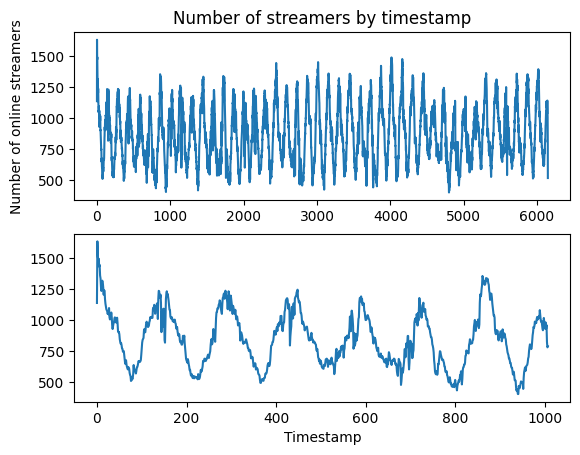

In [18]:
plt.subplot(2,1,1)
plt.plot(cnt)
plt.title('Number of streamers by timestamp')
plt.ylabel('Number of online streamers')

plt.subplot(2,1,2)
plt.plot(cnt[:7*one_day_multiplier])
plt.xlabel('Timestamp')
plt.show()

In [17]:
numSPerTime = dict()
for i in range(0,6148):
    tmp = twitch[(twitch['start']<=i) & (twitch['end']>=i)]
    numSPerTime[i] = len(tmp['streamerID'].unique())

Text(0, 0.5, 'Number of online streamers')

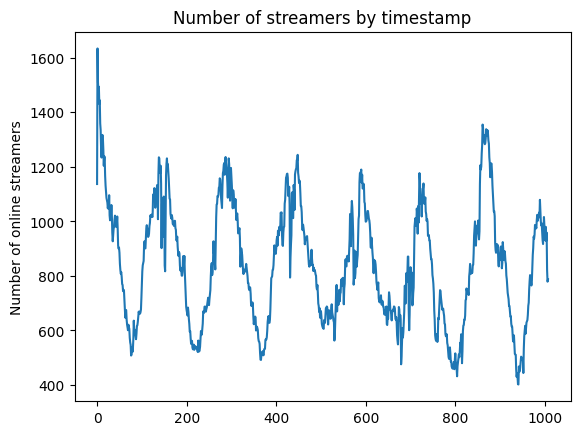

In [19]:
plt.plot(list(numSPerTime.keys())[:7*one_day_multiplier], list(numSPerTime.values())[:7*one_day_multiplier])
plt.title('Number of streamers by timestamp')
plt.ylabel('Number of online streamers')

In [20]:
sPerUser = defaultdict(set)
userPerS = defaultdict(set)
for _,row in twitch.iterrows():
    sPerUser[row['uid']].add(row['sname'])
    userPerS[row['sname']].add(row['uid'])

In [21]:
print('Statistics of streamersPerUser  :',return_statistics([len(s) for _,s in sPerUser.items()]))
print('Statistics of usersPerStreamer  :',return_statistics([len(u) for _,u in userPerS.items()]))

Statistics of streamersPerUser  : {'min': 1, 'q1': 5.0, 'median': 10.0, 'q3': 19.0, 'max': 295}
Statistics of usersPerStreamer  : {'min': 1, 'q1': 1.0, 'median': 1.0, 'q3': 3.0, 'max': 17154}


In [22]:
streamersPerUser = defaultdict(dict)

for i, row in twitch.iterrows():
    if row['sname'] in streamersPerUser[row['uid']].keys():
        streamersPerUser[row['uid']][row['sname']] += 1
    else:
        streamersPerUser[row['uid']][row['sname']] = 1

## Prediction

In [23]:
train = twitch[twitch['start'] < 6147-2*250]
notTrain = twitch[twitch['start'] >= 6147-2*250]

# valid set is one immediate future prediction for every user
# NOTE not every user from train appears in valid
min_start_index = notTrain.groupby('uid')['start'].idxmin()
valid = notTrain.loc[min_start_index]

In [24]:
valid.head(3)

,uid,sid,sname,start,end,streamerID
46,1,34376626624,kendinemuzisyen,5736,5743,4813580760500787061
84,2,34371927952,grma1717,5651,5654,6342438293281875280
103,3,34378397120,wearethevr,5721,5728,1817492062298331871


In [25]:
userIDs = {}
itemIDs = {}
interactions = []
interactionsPerUser = defaultdict(list)

for idx, row in train.iterrows():
    u = row['uid']
    i = row['streamerID']
    t = row['start']
    if not u in userIDs: userIDs[u] = len(userIDs)
    if not i in itemIDs: itemIDs[i] = len(itemIDs)
    interactions.append((t,u,i))
    interactionsPerUser[u].append((t,i))

In [26]:
validinteractionsPerUser = defaultdict(list)
validinteractions = []

for idx, row in valid.iterrows():
    u = row['uid']
    i = row['streamerID']
    t = row['start']
    validinteractions.append((t,u,i))
    validinteractionsPerUser[u].append((t,i))

In [27]:
# interaction with timestamp (timestamp, uid, iid)
interactions[0]

(154, 1, -3305700978989721340)

In [29]:
itemIDs['dummy'] = len(itemIDs)

In [31]:
interactionsWithPrevious = []

for u in interactionsPerUser:
    interactionsPerUser[u].sort()
    lastItem = 'dummy'
    for (t,i) in interactionsPerUser[u]:
        interactionsWithPrevious.append((t,u,i,lastItem))
        lastItem = i

# timestamp, uid, iid, previous_iid
interactionsWithPrevious[0]

(154, 1, -3305700978989721340, 'dummy')

In [32]:
validinteractionsWithPrevious = []

for u in validinteractionsPerUser:
    validinteractionsPerUser[u].sort()
    lastItem = 'dummy'
    for (t,i) in validinteractionsPerUser[u]:
        validinteractionsWithPrevious.append((t,u,i,lastItem))
        lastItem = i

# timestamp, uid, iid, previous_iid
validinteractionsWithPrevious[0]

(5736, 1, 4813580760500787061, 'dummy')

In [33]:
validinteractionsWithPrevious = []
count = 0
for uid, data in validinteractionsPerUser.items():
    tmp = train[train['uid']==uid].sort_values(by='start').iloc[-2:]
    if len(tmp) >= 2:
        validinteractionsWithPrevious.append((data[0][0],uid,data[0][1],tmp.iloc[-1]['streamerID']))
    else:
        count += 1

print('Excluded due to insufficient data:', count)
print('Num of interactions in valid set:', len(validinteractionsWithPrevious))

Excluded due to insufficient data: 699
Num of interactions in valid set: 59828


In [35]:
itemsPerUser = defaultdict(set)
for _,u,i in interactions:
    itemsPerUser[u].add(i)

In [36]:
items = list(itemIDs.keys())

## Model

In [106]:
optimizer = tf.keras.optimizers.legacy.Adam(0.1)

class FPMC(tf.keras.Model):
    def __init__(self, K, lamb, UI = 1, IJ = 1, is_PRME = False):
        super(FPMC, self).__init__()
        # Initialize variables
        self.betaI = tf.Variable(tf.random.normal([len(itemIDs)],stddev=0.001))
        self.gammaUI = tf.Variable(tf.random.normal([len(userIDs),K],stddev=0.001))
        self.gammaIU = tf.Variable(tf.random.normal([len(itemIDs),K],stddev=0.001))
        self.gammaIJ = tf.Variable(tf.random.normal([len(itemIDs),K],stddev=0.001))
        self.gammaJI = tf.Variable(tf.random.normal([len(itemIDs),K],stddev=0.001))

        # Regularization coefficient
        self.lamb = lamb
        # Which terms to include
        self.UI = UI
        self.IJ = IJ

        self.is_PRME = is_PRME


    # Prediction for a single instance
    def predict(self, u, i, j):
        if self.is_PRME:
            item_iteraction = -1 * self.IJ * tf.norm(self.gammaIJ[i] - self.gammaJI[j], axis=-1)
        else:
            item_iteraction = self.IJ * tf.tensordot(self.gammaIJ[i], self.gammaJI[j], 1)

        p = self.betaI[i] + self.UI * tf.tensordot(self.gammaUI[u], self.gammaIU[i], 1) +\
                            item_iteraction

        return p


    # Regularizer
    def reg(self):
        return self.lamb * (tf.nn.l2_loss(self.betaI) +\
                            tf.nn.l2_loss(self.gammaUI) +\
                            tf.nn.l2_loss(self.gammaIU) +\
                            tf.nn.l2_loss(self.gammaIJ) +\
                            tf.nn.l2_loss(self.gammaJI))


    def call(self, sampleU, # user
                   sampleI, # item
                   sampleJ, # previous item
                   sampleK): # negative item   NOTE current negative item
        u = tf.convert_to_tensor(sampleU, dtype=tf.int32)
        i = tf.convert_to_tensor(sampleI, dtype=tf.int32)
        j = tf.convert_to_tensor(sampleJ, dtype=tf.int32)
        k = tf.convert_to_tensor(sampleK, dtype=tf.int32)

        gamma_ui = tf.nn.embedding_lookup(self.gammaUI, u)
        gamma_iu = tf.nn.embedding_lookup(self.gammaIU, i)
        gamma_ij = tf.nn.embedding_lookup(self.gammaIJ, i)
        gamma_ji = tf.nn.embedding_lookup(self.gammaJI, j)
        beta_i = tf.nn.embedding_lookup(self.betaI, i)

        if self.is_PRME:
            ij_interaction = -1 * tf.norm(gamma_ij - gamma_ji, axis=1)
        else:
            ij_interaction = tf.reduce_sum(tf.multiply(gamma_ij, gamma_ji), 1)
        x_uij = beta_i + self.UI * tf.reduce_sum(tf.multiply(gamma_ui, gamma_iu), 1) +\
                         self.IJ * ij_interaction

        # for negative sample
        gamma_uk = tf.nn.embedding_lookup(self.gammaUI, u)
        gamma_ku = tf.nn.embedding_lookup(self.gammaIU, k)
        gamma_kj = tf.nn.embedding_lookup(self.gammaIJ, k)
        gamma_jk = tf.nn.embedding_lookup(self.gammaJI, j)
        beta_k = tf.nn.embedding_lookup(self.betaI, k)

        if self.is_PRME:
            kj_interaction = -1 * tf.norm(gamma_kj - gamma_jk, axis=1)
        else:
            kj_interaction = tf.reduce_sum(tf.multiply(gamma_kj, gamma_jk), 1)
        x_ukj = beta_k + self.UI * tf.reduce_sum(tf.multiply(gamma_uk, gamma_ku), 1) +\
                         self.IJ * kj_interaction

        loss = -tf.reduce_mean(tf.math.log(tf.math.sigmoid(x_uij - x_ukj)))

        return loss

In [43]:
streamersPerTime = defaultdict(set)

for d in interactionsWithPrevious:
    streamersPerTime[d[0]].add(d[2])


def trainingStep(model, interactions):
    with tf.GradientTape() as tape:
        sampleU, sampleI, sampleJ, sampleK = [], [], [], []
        for _ in range(100000):
            t,u,i,j = random.choice(interactions) # positive sample
            k = random.choice(list(streamersPerTime[t])) # negative sample from available streamers
            # if the negative sample is an item that a user previously interacted with, sample again
            while k in itemsPerUser[u]:
                k = random.choice(items)
            sampleU.append(userIDs[u])
            sampleI.append(itemIDs[i])
            sampleJ.append(itemIDs[j])
            sampleK.append(itemIDs[k])

        loss = model(sampleU,sampleI,sampleJ,sampleK)
        loss += model.reg()
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients((grad, var) for
                              (grad, var) in zip(gradients, model.trainable_variables)
                              if grad is not None)
    return loss.numpy()

## Training

In [98]:
def training(model):
    min_obj = 100
    count = 0
    model_objs = []

    for i in range(2000):
        obj = trainingStep(model, interactionsWithPrevious)
        model_objs.append(obj)

        if obj < min_obj:
            min_obj = obj
            count = 0
        else:
            count += 1

        if i > 100 and count > 30:
            print('Early stopping')
            break

        if (i % 10 == 9):
            print("iteration " + str(i+1) + ", objective = " + str(obj))

    return model_objs

In [90]:
modelMF = FPMC(4, 0.000002, 1, 0)  # baseline2
modelMF_objs = training(modelMF)

iteration 10, objective = 0.61807853
iteration 20, objective = 0.52282906
iteration 30, objective = 0.50955397
iteration 40, objective = 0.48593128
iteration 50, objective = 0.45976692
iteration 60, objective = 0.44535592
iteration 70, objective = 0.43778002
iteration 80, objective = 0.42874515
iteration 90, objective = 0.4237576
iteration 100, objective = 0.4220332
iteration 110, objective = 0.41761756
iteration 120, objective = 0.4149742
iteration 130, objective = 0.4141377
iteration 140, objective = 0.41031966
iteration 150, objective = 0.41056973
iteration 160, objective = 0.41169286
iteration 170, objective = 0.40732616
iteration 180, objective = 0.408013
iteration 190, objective = 0.40843666
iteration 200, objective = 0.40683204
iteration 210, objective = 0.40220988
iteration 220, objective = 0.40624374
iteration 230, objective = 0.40211302
iteration 240, objective = 0.40062827
iteration 250, objective = 0.40366966
iteration 260, objective = 0.40042382
iteration 270, objective = 

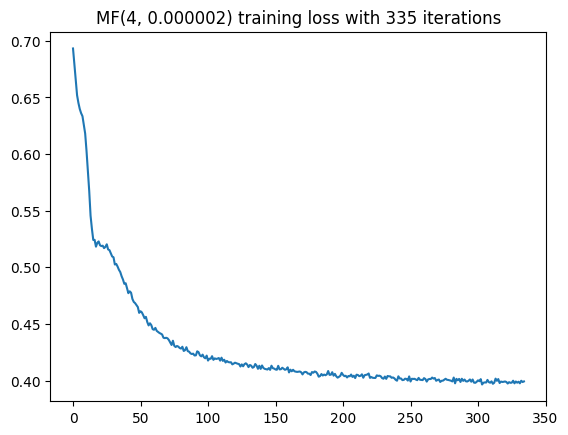

In [93]:
plt.plot(modelMF_objs)
plt.title('MF(4, 0.000002) training loss with 335 iterations')
plt.show()

In [114]:
modelMF.save_weights('model/MF/checkpoint')

#modelMF = FPMC(4, 0.000002, 1, 0)
#modelMF.load_weights('model/MF/checkpoint')

In [72]:
modelFPMC = FPMC(4, 0.000002)
modelFPMC_objs = training(modelFPMC)

iteration 10, objective = 0.56902206
iteration 20, objective = 0.44632038
iteration 30, objective = 0.4090171
iteration 40, objective = 0.3895551
iteration 50, objective = 0.38280427
iteration 60, objective = 0.37064826
iteration 70, objective = 0.36677504
iteration 80, objective = 0.36175773
iteration 90, objective = 0.3610301
iteration 100, objective = 0.36139518
iteration 110, objective = 0.3607753
iteration 120, objective = 0.36054295
iteration 130, objective = 0.36163354
iteration 140, objective = 0.35884088
iteration 150, objective = 0.3610755
Early stopping


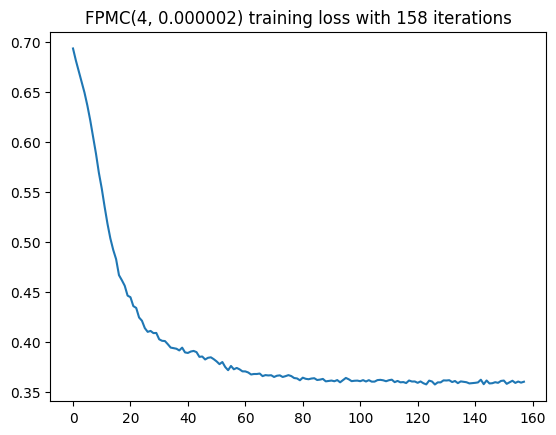

In [76]:
plt.plot(modelFPMC_objs)
plt.title('FPMC(4, 0.000002) training loss with 158 iterations')
plt.show()

In [124]:
modelFPMC.save_weights('model/FPMC/checkpoint')

#modelFPMC = FPMC(4, 0.00002)
#modelFPMC.load_weights('model/FPMC/checkpoint')

In [107]:
modelPRME = FPMC(5, 0.000000008, is_PRME=True)
modelPRME_objs = training(modelPRME)

iteration 10, objective = 0.5676784
iteration 20, objective = 0.38682458
iteration 30, objective = 0.25899106
iteration 40, objective = 0.20579502
iteration 50, objective = 0.17576176
iteration 60, objective = 0.15534633
iteration 70, objective = 0.14321385
iteration 80, objective = 0.1349701
iteration 90, objective = 0.1273997
iteration 100, objective = 0.12432114
iteration 110, objective = 0.120439395
iteration 120, objective = 0.11732064
iteration 130, objective = 0.11478195
iteration 140, objective = 0.113775216
iteration 150, objective = 0.1077972
iteration 160, objective = 0.11023148
iteration 170, objective = 0.10896831
iteration 180, objective = 0.105695724
iteration 190, objective = 0.10436417
iteration 200, objective = 0.10528298
iteration 210, objective = 0.10217968
iteration 220, objective = 0.104622096
iteration 230, objective = 0.102266796
iteration 240, objective = 0.10469156
iteration 250, objective = 0.10278733
iteration 260, objective = 0.10086162
iteration 270, objec

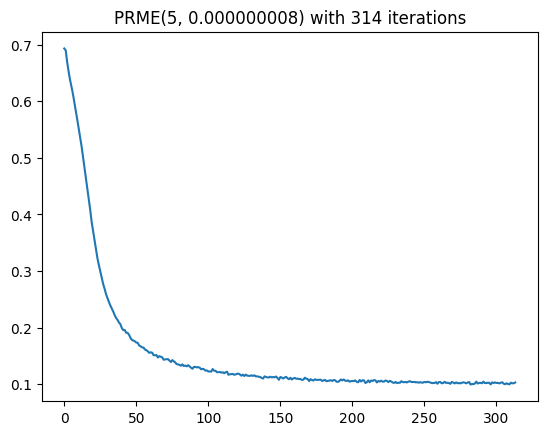

In [109]:
plt.plot(modelPRME_objs)
plt.title('PRME(5, 0.000000008) with 314 iterations')
plt.show()

In [113]:
modelPRME.save_weights('model/PRME/checkpoint')

#modelPRME = FPMC(5, 0.000000008, is_PRME=True)
#modelPRME.load_weights('model/PRME/checkpoint')

## Evaluation

In [47]:
# all available streamers in the valid set time window

validStreamersPerTime = defaultdict(set)

for i, row in notTrain.iterrows():
    validStreamersPerTime[row['start']].add(row['streamerID'])

In [51]:
streamerUserPair = dict()
for d in validinteractionsWithPrevious[1000:2000]:
    streamerUserPair[d[1]] = d[2]

count = 0
uids = []
new_uids = []
for u,s in streamerUserPair.items():
    if s in train[train['uid']==u]['streamerID'].values:
        count += 1
        uids.append(u)
    else:
        new_uids.append(u)
print('Number of repeat consumption out of 1000 interactions:', count)

Number of repeat consumption out of 1000 interactions: 642


In [65]:
def rank_all(model):
    all_result = defaultdict(list)
    for (t,uid,_,psid) in validinteractionsWithPrevious[1000:2000]:
        # ranking all available streamers
        result = dict()
        for sid in validStreamersPerTime[t]:
            # if item not seen in the train set, score 0
            if sid not in itemIDs:
                result[sid] = 0
            else:
                s = model.predict(userIDs[uid], itemIDs[sid], itemIDs[psid]).numpy()
                result[sid] = s
        sorted_result = dict(sorted(result.items(), key=lambda item: item[1], reverse=True))
        all_result[uid] = list(sorted_result.keys())
    
    return all_result


def precisionAtK_long(all_result, mode, k=10):
    ''' mode 1 : all, 2 : repeat, 3 : new '''
    precAtK = []
    for d in validinteractionsWithPrevious[1000:2000]:
        uid = d[1]

        if mode == 2 and uid not in new_uids:
            if d[2] in all_result[uid][:k]:
                precAtK.append(True)
            else:
                precAtK.append(False)
        elif mode == 3 and uid in new_uids:
            if d[2] in all_result[uid][:k]:
                precAtK.append(True)
            else:
                precAtK.append(False)
        elif mode == 1:
            if d[2] in all_result[uid][:k]:
                precAtK.append(True)
            else:
                precAtK.append(False)


    return sum(precAtK) / len(precAtK)


def precisionAtK(all_result, mode, k=10):
    ''' mode 1 : all, 2 : repeat, 3 : new '''
    precAtK = []

    for d in validinteractionsWithPrevious[1000:2000]:
        uid, item = d[1], d[2]

        valid_condition = (mode == 2 and uid not in new_uids) \
                            or (mode == 3 and uid in new_uids) \
                            or mode == 1

        # include eval metric score only if one of the conditions has met
        if valid_condition:
            if item in all_result[uid][:k]:
                precAtK.append(True)
            else:
                precAtK.append(False)

    return sum(precAtK) / len(precAtK)


def mrr(all_result):
    mrr = []
    not_found_cnt = []
    for d in validinteractionsWithPrevious[1000:2000]:
        uid = d[1]
        if d[2] in all_result[uid]:
            mrr.append(list(all_result[uid]).index(d[2]))
        else:
            # new item
            not_found_cnt.append(d[2])

    return np.mean([1/(r+1) for r in mrr]), not_found_cnt


In [94]:
MF_all_result = rank_all(modelMF)

In [95]:
for mode in [1,2,3]:
    for k in ['01','06','10']:
        mode_str = ''
        if mode == 1:
            mode_str = 'all'
        elif mode == 2:
            mode_str = 'old'
        else:
            mode_str = 'new'
        print(f'Precision@{k}_{mode_str}:', precisionAtK(MF_all_result, mode, int(k)))

print('Mean_reciprocal_rank:', mrr(MF_all_result)[0])

Precision@01_all: 0.123
Precision@06_all: 0.38
Precision@10_all: 0.471
Precision@01_old: 0.16822429906542055
Precision@06_old: 0.48442367601246106
Precision@10_old: 0.5903426791277259
Precision@01_new: 0.04189944134078212
Precision@06_new: 0.19273743016759776
Precision@10_new: 0.2569832402234637
Mean_reciprocal_rank: 0.23129601277187434


In [77]:
FPMC_all_result = rank_all(modelFPMC)

In [89]:
for mode in [1,2,3]:
    for k in ['01','06','10']:
        mode_str = ''
        if mode == 1:
            mode_str = 'all'
        elif mode == 2:
            mode_str = 'old'
        else:
            mode_str = 'new'
        print(f'Precision@{k}_{mode_str}:', precisionAtK(FPMC_all_result, mode, int(k)))

print('Mean_reciprocal_rank:', mrr(FPMC_all_result)[0])


Precision@01_all: 0.158
Precision@06_all: 0.476
Precision@10_all: 0.56
Precision@01_old: 0.2087227414330218
Precision@06_old: 0.5919003115264797
Precision@10_old: 0.677570093457944
Precision@01_new: 0.0670391061452514
Precision@06_new: 0.2681564245810056
Precision@10_new: 0.34916201117318435
Mean_reciprocal_rank: 0.28742431830901377


In [110]:
PRME_all_result = rank_all(modelPRME)

In [111]:
for mode in [1,2,3]:
    for k in ['01','06','10']:
        mode_str = ''
        if mode == 1:
            mode_str = 'all'
        elif mode == 2:
            mode_str = 'old'
        else:
            mode_str = 'new'
        print(f'Precision@{k}_{mode_str}:', precisionAtK(PRME_all_result, mode, int(k)))

print('Mean_reciprocal_rank:', mrr(PRME_all_result)[0])

Precision@01_all: 0.226
Precision@06_all: 0.574
Precision@10_all: 0.659
Precision@01_old: 0.30218068535825543
Precision@06_old: 0.6838006230529595
Precision@10_old: 0.7632398753894081
Precision@01_new: 0.0893854748603352
Precision@06_new: 0.3770949720670391
Precision@10_new: 0.4720670391061452
Mean_reciprocal_rank: 0.36722135421872065


## Baseline 1

In [54]:
baseline_all_result = defaultdict(list)
for d in validinteractionsWithPrevious[1000:2000]:
    uid = d[1]
    history = train.groupby(['uid', 'streamerID'])['sid'].count()
    history = history.reset_index()
    baseline_all_result[uid] = history[history['uid']==uid].sort_values(by='sid', ascending=False)['streamerID'].values

In [97]:
for mode in [1,2,3]:
    for k in ['01','06','10']:
        mode_str = ''
        if mode == 1:
            mode_str = 'all'
        elif mode == 2:
            mode_str = 'old'
        else:
            mode_str = 'new'
        print(f'Precision@{k}_{mode_str}:', precisionAtK(baseline_all_result, mode, int(k)))

print('Mean_reciprocal_rank:', mrr(baseline_all_result)[0])

Precision@01_all: 0.201
Precision@06_all: 0.466
Precision@10_all: 0.544
Precision@01_old: 0.3130841121495327
Precision@06_old: 0.7258566978193146
Precision@10_old: 0.8473520249221184
Precision@01_new: 0.0
Precision@06_new: 0.0
Precision@10_new: 0.0
Mean_reciprocal_rank: 0.48140604504059287
